# Stability and Energy in Numerical Time-Stepping

In this project, I explored how different time-integration methods (Implicit Euler, Explicit Euler) behave in **PDEs and ODEs**.  
Using the **heat equation** discretized with FEM and the **harmonic oscillator**, I analyzed **convergence, stability thresholds, and energy behavior**.

---

## 🔹 Motivation
Time-stepping methods are the backbone of numerical PDE/ODE solvers.  
But:
- Some are stable for any step size (implicit methods),  
- Some require step size restrictions tied to spectral properties (explicit methods),  
- And few preserve the true physics (like energy conservation).  

This project demonstrates these aspects in action.

---

## 🔹 Problems Studied

### 1. Heat Equation with FEM + Implicit Euler
We solve
$$
u_t - u_{xx} = f, \quad u(0,t)=u(1,t)=0, \quad u(x,0)=u_0(x)
$$
using **piecewise linear FEM** in space and **Implicit Euler** in time.

- **Method:** Assemble mass matrix $M$ and stiffness matrix $A$, step with  
  $$
  (M + kA)u^{n+1} = Mu^n + kf^{n+1}.
  $$
- **Validation:** Exact solution $u(x,t) = e^{-t}x(1-x)$.  
- **Error metric:** discrete $L^2$-norm at final time $T=1$.  
- **Result:** Convergence of order $\mathcal{O}(h)$.

---

### 2. Heat Equation with Explicit Euler
We repeat the above but use **Explicit Euler**:
$$
u^{n+1} = u^n - k M^{-1}A u^n + kM^{-1}f^n.
$$

- Stability condition:  
  $$
  k < \frac{2}{\lambda_{\max}(M^{-1}A)}.
  $$
- **Experiment:**  
  - $k = \tfrac{1.99}{\lambda_{\max}}$ → stable.  
  - $k = \tfrac{2.01}{\lambda_{\max}}$ → blow-up.  
- **Result:** Confirmed CFL-type restriction.  
- **Observation:** $\lambda_{\max}(M^{-1}A) \sim \mathcal{O}(h^{-2})$, so explicit methods require very small $k$.

---

### 3. Harmonic Oscillator (Energy Preservation)
We consider the ODE
$$
u'' + u = 0, \quad u(0)=u_0, \; u'(0)=v_0.
$$
Introduce $v=u'$ and solve with Euler schemes.

- **Exact energy:**  
  $$
  E(t) = \tfrac12 |u(t)|^2 + \tfrac12 |v(t)|^2, \quad \text{conserved}.
  $$

- **Discrete energies:**  
  - Explicit Euler: energy **grows** (unstable).  
  - Implicit Euler: energy **decays** (over-damped).  
  - Exact solution: energy constant.

- **Result:** Neither scheme preserves physics; confirms stability vs. energy tradeoff.

---

## 🔹 Key Takeaways
- **Implicit Euler:**  
  - Unconditionally stable.  
  - Dissipative (damps energy).  

- **Explicit Euler:**  
  - Stability depends on $k < 2/\lambda_{\max}$.  
  - Energy can grow and cause blow-up.  

- **Physics-aware insight:**  
  - Exact solutions conserve energy; numerical schemes distort it.  
  - Stability and accuracy must be balanced with the physics of the problem.  




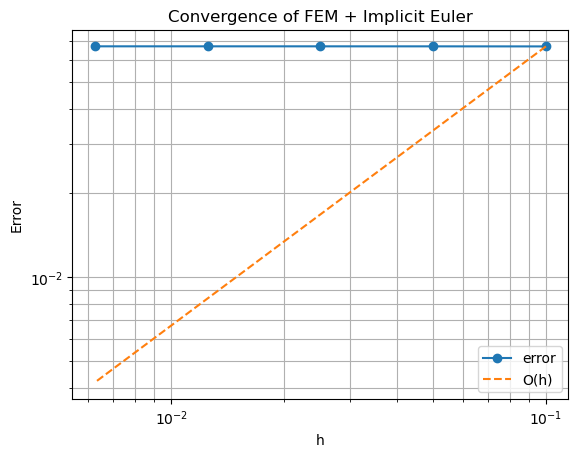

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

def heat_equation_solver(N, c):
    # spatial discretization
    h = 1.0 / N
    x = np.linspace(0, 1, N + 1)
    interior = np.arange(1, N)  # indices of interior nodes

    # time step
    k = c * h
    T = 1.0
    Nt = int(T / k)

    # basis: linear elements, so assemble mass and stiffness matrices
    main_diag_M = 4 * np.ones(N - 1)
    off_diag_M = np.ones(N - 2)
    M = (h / 6) * (np.diag(main_diag_M) + np.diag(off_diag_M, 1) + np.diag(off_diag_M, -1))

    main_diag_A = 2 * np.ones(N - 1)
    off_diag_A = -1 * np.ones(N - 2)
    A = (1 / h) * (np.diag(main_diag_A) + np.diag(off_diag_A, 1) + np.diag(off_diag_A, -1))

    #lhs matrix: M + k*A
    LHS = M + k * A

    # initial condition: u(x,0) = x(1-x)
    u0 = x[interior] * (1 - x[interior])
    U = u0.copy()

    # time stepping
    for _ in range(Nt):
        RHS = M @ U
        U = spla.spsolve(sp.csr_matrix(LHS), RHS)

    # exact solution at T=1
    u_exact = np.exp(-1) * x[interior] * (1 - x[interior])

    # compute discrete L2 error
    error = np.sqrt(h * np.sum((U - u_exact)**2))
    return h, error

# run for various mesh sizes
Ns = [10, 20, 40, 80, 160]
c = 0.5
errors = []
hs = []

for N in Ns:
    h, err = heat_equation_solver(N, c)
    hs.append(h)
    errors.append(err)

import matplotlib.pyplot as plt
plt.loglog(hs, errors, marker='o', label='error')
plt.loglog(hs, [errors[0]*(h/hs[0]) for h in hs], '--', label='O(h)')
plt.xlabel('h')
plt.ylabel('Error')
plt.title('Convergence of FEM + Implicit Euler')
plt.legend()
plt.grid(True, which='both')
plt.show()


/var/folders/gw/v0pp8hwn2m93b42fvkh1qztc0000gn/T/ipykernel_50837/1693554642.py:43: RuntimeWarning: overflow encountered in square
  error = np.sqrt(h * np.sum((U - u_exact)**2))


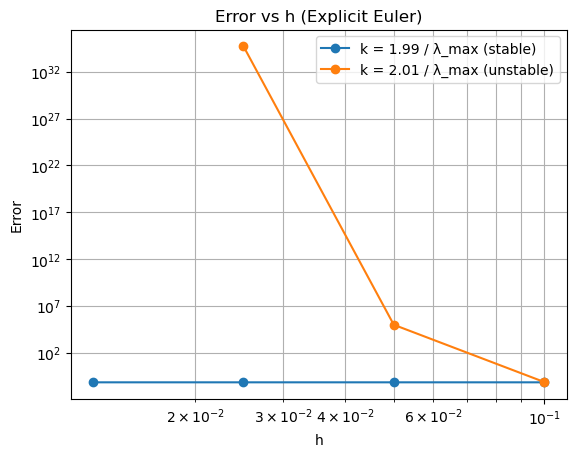

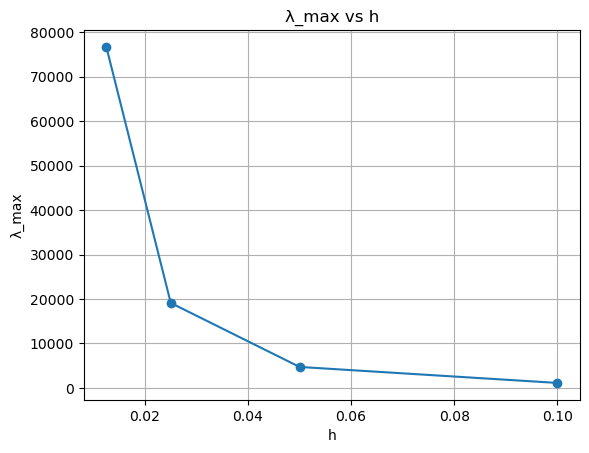

In [2]:

def explicit_euler_heat(N, factor):
    h = 1.0 / N
    x = np.linspace(0, 1, N + 1)
    interior = np.arange(1, N)

    # assemble mass matrix M and stiffness matrix A
    main_diag_M = 4 * np.ones(N - 1)
    off_diag_M = np.ones(N - 2)
    M = (h / 6) * (np.diag(main_diag_M) + np.diag(off_diag_M, 1) + np.diag(off_diag_M, -1))

    main_diag_A = 2 * np.ones(N - 1)
    off_diag_A = -1 * np.ones(N - 2)
    A = (1 / h) * (np.diag(main_diag_A) + np.diag(off_diag_A, 1) + np.diag(off_diag_A, -1))

    # compute largest eigenvalue of M^{-1} A
    MinvA = np.linalg.inv(M) @ A
    lambda_max = np.linalg.eigvalsh(MinvA).max()

    # set time step based on given factor
    k = factor / lambda_max
    T = 1.0
    Nt = int(T / k)

    # initial condition
    u0 = x[interior] * (1 - x[interior])
    U = u0.copy()

    # exp Euler time stepping
    Minv = np.linalg.inv(M)
    for _ in range(Nt):
        U = U - k * (Minv @ (A @ U))

    # exact sol at T = 1
    u_exact = np.exp(-1) * x[interior] * (1 - x[interior])
    
    error = np.sqrt(h * np.sum((U - u_exact)**2))

    return h, error, lambda_max

# run for various N and two different k factors
Ns = [10, 20, 40, 80]
errors_199 = []
errors_201 = []
hs = []
lambdas = []

for N in Ns:
    h, err_201, lam = explicit_euler_heat(N, factor=2.01)
    _, err_199, _ = explicit_euler_heat(N, factor=1.99)
    hs.append(h)
    errors_201.append(err_201)
    errors_199.append(err_199)
    lambdas.append(lam)

# Plot error vs h
plt.figure()
plt.loglog(hs, errors_199, 'o-', label='k = 1.99 / λ_max (stable)')
plt.loglog(hs, errors_201, 'o-', label='k = 2.01 / λ_max (unstable)')
plt.xlabel('h')
plt.ylabel('Error')
plt.title('Error vs h (Explicit Euler)')
plt.grid(True, which='both')
plt.legend()

# Plot lambda_max vs h
plt.figure()
plt.plot(hs, lambdas, 'o-')
plt.xlabel('h')
plt.ylabel('λ_max')
plt.title('λ_max vs h')
plt.grid(True)

plt.show()


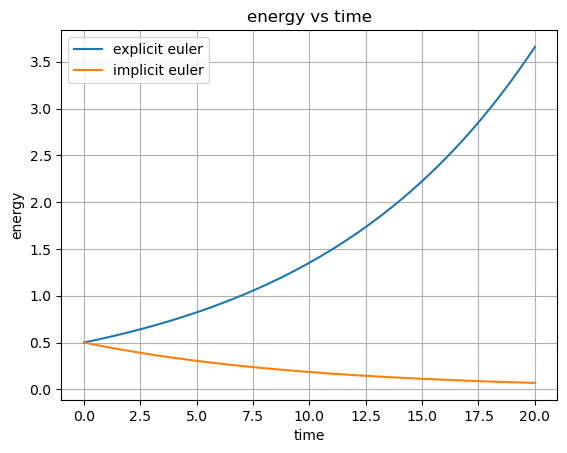

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# parameters
T = 20               # total time
k = 0.1              # time step
N = int(T / k)       # number of time steps

# initial conditions
u0 = 1.0             # initial displacement
v0 = 0.0             # initial velocity

# create arrays for explicit and implicit Euler
u_exp = np.zeros(N+1)
v_exp = np.zeros(N+1)
u_imp = np.zeros(N+1)
v_imp = np.zeros(N+1)

# set initial values
u_exp[0] = u0
v_exp[0] = v0
u_imp[0] = u0
v_imp[0] = v0

# store energy over time
energy_exp = np.zeros(N+1)
energy_imp = np.zeros(N+1)

# compute initial energies
energy_exp[0] = 0.5 * u0**2 + 0.5 * v0**2
energy_imp[0] = 0.5 * u0**2 + 0.5 * v0**2

# explicit Euler loop
for n in range(N):
    u_exp[n+1] = u_exp[n] + k * v_exp[n]
    v_exp[n+1] = v_exp[n] - k * u_exp[n]
    energy_exp[n+1] = 0.5 * u_exp[n+1]**2 + 0.5 * v_exp[n+1]**2

# implicit Euler loop
for n in range(N):
    # solve the coupled system:
    # u_{n+1} = u_n + k * v_{n+1}
    # v_{n+1} = v_n - k * u_{n+1}
    # substitute v_{n+1} into the first equation
    denom = 1 + k**2
    u_next = (u_imp[n] + k * v_imp[n]) / denom
    v_next = v_imp[n] - k * u_next
    u_imp[n+1] = u_next
    v_imp[n+1] = v_next
    energy_imp[n+1] = 0.5 * u_next**2 + 0.5 * v_next**2

# plot energy over time
time = np.linspace(0, T, N+1)
plt.plot(time, energy_exp, label="explicit euler")
plt.plot(time, energy_imp, label="implicit euler")
plt.xlabel("time")
plt.ylabel("energy")
plt.title("energy vs time")
plt.legend()
plt.grid(True)
plt.show()
